# Part 1: Perceptron Classifier Construction

Generate data consisting of 100 two-dimensional vectors taken from a normal distribution with μ1 = [0,0]T ,σ1 = I and label them as class ”-1”. Form a class ”-1” training subset by setting aside 50 points and let the remaining 50 points serve as part of the test set. 

Do the same for class ”+1” for another normal distribution with μ2 = [10,10]T ,σ2 = I. Merge the subsets to form the training and test sets.

In [1]:
# This code generates the initial dataset for part 1
import numpy as np

mu1 = [0,0]
mu2 = [10,10]
sigma1 = np.eye(2)
sigma2 = np.eye(2)

pos_dist = np.random.multivariate_normal(mu1, sigma1, 100)
neg_dist = np.random.multivariate_normal(mu2, sigma2, 100)

positive_labels = np.ones(100)
negative_labels = np.ones(100) * -1

x_train = np.vstack((pos_dist[:50], neg_dist[:50]))
x_test = np.vstack((pos_dist[50:], pos_dist[50:]))
y_train = np.hstack((positive_labels[:50], negative_labels[:50]))
y_test = np.hstack((positive_labels[50:], negative_labels[50:]))


Write code named classify(···) that implements the Pocket Algorithm for perceptron learning. Set maxitercnt to 10000 iterations.

In [2]:
def classify(train_x, train_y, maxitercnt=10000, random_state=42):
    rng = np.random.default_rng(random_state)
    w_pocket = None

    N, d = train_x.shape

    # Augment X with a column of 1s for the bias term.
    X_aug = np.hstack([np.ones((N, 1)), train_x])

    # Set nv = nw = 0 and vi = wi = 0 for i =0,1,...,d; Set itercnt = 0
    v = np.zeros(d + 1)
    w = np.zeros(d + 1)
    nv = 0
    nw = 0
    itercnt = 0

    while itercnt < maxitercnt:
        # Randomly choose an input pattern xj and associated label yj from the training set
        j = rng.integers(low=0, high=N)
        xj = X_aug[j]
        yj = train_y[j]

        # Compute the neuron’s output given x
        y_hat = 1 if np.dot(v, xj) >= 0 else -1

        # If v correctly classifies xj (i.e, ˆyj yj > 0) then set nv = nv + 1
        if y_hat == yj:
            nv += 1
        # Otherwise
        else:
            # if nv > nw then
            if nv > nw:
                # set w = v and nw = nv (put current vector in the pocket)
                w = v.copy()
                nw = nv
            # change vector v by setting vi = vi + yj xij for i = 0,1,...,d. (note: xij is the ith element of sample xj )
            v = v + yj * xj
            # set nv = 0
            nv = 0

        # itercnt = itercnt + 1
        itercnt += 1

    # Just check one last time:
    # if nv > nw then
    if nv > nw:
        # set w = v and nw = nv (put current vector in the pocket)
        w = v.copy()
        nw = nv

    w_pocket = w
    return w_pocket
    
w_pocket = classify(x_train, y_train, maxitercnt=10_000)

Write code named predict(···) to test the classifier and measure the sum of square errors for the test set.

In [3]:
def predict(X: np.ndarray, w_pocket=None) -> np.ndarray:
    if w_pocket is None:
        raise ValueError("Model has not been trained yet.")

    M, _ = X.shape
    X_aug = np.hstack([np.ones((M, 1)), X])
    raw_scores = X_aug.dot(w_pocket)
    y_pred = np.where(raw_scores >= 0, 1, -1)
    return y_pred

y_pred = predict(x_test, w_pocket)

sse = np.sum((y_pred - y_test) ** 2)
print("Sum of Squared Errors (Test Set):", sse)

Sum of Squared Errors (Test Set): 200.0


# Part 2: Adaboost Construction and Evaluation

1. Following the Adaboost pseudocode presented in the previous section, write code called adabtrain that implements the Adaboost algorithm with the Pocket Algorithm as the basic learner. Write code named adabpredict that classifies unknown/unseen data.

In [4]:
def adabtrain(x_train, y_train, K=10, max_iter_weak=10_000, random_state=42, verbose=False):
    learners = []
    alphas = []
    rng = np.random.default_rng(random_state)

    N, _ = x_train.shape
    # 1) Initialize w1(i) = 1/N. (uniform distribution over data)
    sample_weights = np.ones(N) / N

    # 2) for t = 1,...,K
    for t in range(K):
        # a) Select new training set St from S with replacement according to wt
        indices = rng.choice(N, size=N, replace=True, p=sample_weights)
        X_t, y_t = x_train[indices], y_train[indices]

        # b) Train weak learner L on St to obtain hypothesis ht
        w_pocket = classify(X_t, y_t, maxitercnt=max_iter_weak, random_state=42)

        # c) Compute training error et of ht on S
        # (Which should be eps_t)
        y_pred_full = predict(x_train, w_pocket)                              # ∈ {+1, -1}^N
        incorrect   = (y_pred_full != y_train).astype(float)              # 1.0 if wrong, 0.0 if correct
        eps_t       = np.sum(sample_weights * incorrect)            # weighted error

        # Additional: If εₜ >= 0.5, flip the weak learner’s predictions so we get εₜ ≤ 0.5
        if eps_t >= 0.5:
            y_pred_full = -y_pred_full
            eps_t       = 1.0 - eps_t

        # d) Compute coefficient at (alpha)
        eps_t = np.clip(eps_t, 1e-10, 1 - 1e-10)
        alpha_t = 0.5 * np.log((1 - eps_t) / eps_t)

        # e) Compute new weights on S (with normalization)
        sample_weights *= np.exp(-alpha_t * y_train * y_pred_full)
        sample_weights /= sample_weights.sum()

        # Save the learners and alpha values
        learners.append(w_pocket)
        alphas.append(alpha_t)
        
        if verbose:
            print(f"Round {t+1}/{K} | εₜ = {eps_t:.4f} | αₜ = {alpha_t:.4f}")
    return learners, alphas


def adabpredict(x_test, learners=None, alphas=None):
    if not learners:
        raise ValueError("The AdaBoost model has not been trained yet.")

    M, _ = x_test.shape
    # For each t, compute h_t(x) ∈ {+1, −1}. Sum α_t * h_t(x) across t.
    agg_scores = np.zeros(M)
    for alpha_t, learner in zip(alphas, learners):
        y_pred = predict(x_test, learner)
        agg_scores += alpha_t * y_pred
    return np.where(agg_scores >= 0, 1, -1)

## Adaboost: Banana dataset

Form the training set by sampling 400 points from the banana dataset provided. Use the remaining 4900 points as your test set.

In [5]:
import pandas as pd

banana_df = pd.read_csv("banana_data.csv", header=None)
banana_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5300 entries, 0 to 5299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5300 non-null   float64
 1   1       5300 non-null   float64
 2   2       5300 non-null   float64
dtypes: float64(3)
memory usage: 124.3 KB


In [6]:
banana_df.describe()

,0,1,2
count,5300.000000,5.300000e+03,5.300000e+03
mean,-0.103396,-3.889076e-10,-3.304355e-10
std,0.994734,1.000000e+00,1.000000e+00
min,-1.000000,-3.089839e+00,-2.385937e+00
25%,-1.000000,-7.533486e-01,-9.139026e-01
50%,-1.000000,-1.523143e-02,-3.721518e-02
75%,1.000000,7.818310e-01,8.221039e-01
max,1.000000,2.813360e+00,3.194302e+00


In [7]:
banana_df.head()

,0,1,2
0,-1.0,-3.089839,-0.831686
1,-1.0,-2.980834,-0.159575
2,-1.0,-2.836057,-0.177081
3,-1.0,-2.767849,0.096217
4,-1.0,-2.600350,0.216772


In [8]:
x = banana_df.iloc[:, 1:].to_numpy()
y = banana_df.iloc[:, 0].to_numpy()

In [9]:
x

array([[-3.0898387 , -0.83168647],
       [-2.9808342 , -0.15957534],
       [-2.8360574 , -0.17708113],
       ...,
       [ 2.7103145 ,  1.3465977 ],
       [ 2.7544469 ,  1.4719528 ],
       [ 2.8133603 ,  1.3016674 ]], shape=(5300, 2))

In [10]:
y

array([-1., -1., -1., ...,  1.,  1.,  1.], shape=(5300,))

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(4900/5300), random_state=42)

Using adabtrain and adabpredict, train the boosted perceptron algorithm and measure the training and test accuracies for the ensemble classifier having K learners.

In [12]:
learners, alphas = adabtrain(x_train, y_train, 10, verbose=True)
y_pred = adabpredict(x_test, learners, alphas)

Round 1/10 | εₜ = 0.3975 | αₜ = 0.2079
Round 2/10 | εₜ = 0.3521 | αₜ = 0.3049
Round 3/10 | εₜ = 0.4098 | αₜ = 0.1825
Round 4/10 | εₜ = 0.3466 | αₜ = 0.3169
Round 5/10 | εₜ = 0.4679 | αₜ = 0.0642
Round 6/10 | εₜ = 0.3985 | αₜ = 0.2059
Round 7/10 | εₜ = 0.4650 | αₜ = 0.0701
Round 8/10 | εₜ = 0.4595 | αₜ = 0.0811
Round 9/10 | εₜ = 0.3997 | αₜ = 0.2034
Round 10/10 | εₜ = 0.4734 | αₜ = 0.0533


Write code that automatically plots the training and test accuracies against the number of learners K used for training. Use K = 10,20,30,...1000.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time

def get_adaboost_analysis(x_train, y_train, x_test, y_test, K_values):
    """
    For each K in K_values:
      - Measure training and test prediction time
      - Compute training and test accuracy
    Then plot both:
      1. Elapsed times vs K
      2. Accuracies vs K
    Also print the best test accuracy and its corresponding K.
    """
    train_times = []
    test_times = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = -1 * np.inf
    best_K = None

    for K in K_values:
        # --- Time the training ---
        t0 = time.perf_counter()
        learners, alphas = adabtrain(x_train, y_train, K)
        t1 = time.perf_counter()
        train_elapsed = t1 - t0
        train_times.append(train_elapsed)

        # --- Accuracy on training data ---
        y_train_pred = adabpredict(x_train, learners, alphas)
        train_acc = np.mean(y_train_pred == y_train)
        train_accuracies.append(train_acc)

        # --- Time the prediction on test set ---
        t2 = time.perf_counter()
        y_test_pred = adabpredict(x_test, learners, alphas)
        t3 = time.perf_counter()
        test_elapsed = t3 - t2
        test_times.append(test_elapsed)

        # --- Accuracy on test data ---
        test_acc = np.mean(y_test_pred == y_test)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_K = K

        print(f"K={K}: train_time={train_elapsed:.4f}s, test_time={test_elapsed:.4f}s, "
              f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")

    # --- Print best result ---
    print(f"\n Best Test Accuracy = {best_test_acc:.4f} at K = {best_K}")
    return K_values, train_times, test_times, train_accuracies, test_accuracies


def plot_adaboost_analysis(K_values, train_times, test_times, train_accuracies, test_accuracies, title):
    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Times
    axs[0].plot(K_values, train_times, label='Training Time (s)', marker='o')
    axs[0].plot(K_values, test_times, label='Test Prediction Time (s)', marker='s')
    axs[0].set_xlabel('Number of Learners (K)')
    axs[0].set_ylabel('Elapsed Time (seconds)')
    axs[0].set_title(f'Training and Prediction Time vs. K\n{title}')
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2: Accuracies
    axs[1].plot(K_values, train_accuracies, label='Train Accuracy', marker='o')
    axs[1].plot(K_values, test_accuracies, label='Test Accuracy', marker='s')
    axs[1].set_xlabel('Number of Learners (K)')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title(f'Training and Test Accuracy vs. K\n{title}')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
K_values = list(range(10, 1001, 10))
K_values, train_times, test_times, train_accuracies, test_accuracies = get_adaboost_analysis(x_train, y_train, x_test, y_test, K_values)

K=10: train_time=0.1998s, test_time=0.0005s, train_acc=0.7825, test_acc=0.7743
K=20: train_time=0.3976s, test_time=0.0008s, train_acc=0.7950, test_acc=0.7729
K=30: train_time=0.6006s, test_time=0.0012s, train_acc=0.8525, test_acc=0.8288
K=40: train_time=0.7731s, test_time=0.0015s, train_acc=0.8550, test_acc=0.8241
K=50: train_time=0.9680s, test_time=0.0020s, train_acc=0.8900, test_acc=0.8629
K=60: train_time=1.1725s, test_time=0.0024s, train_acc=0.8925, test_acc=0.8698
K=70: train_time=1.4779s, test_time=0.0028s, train_acc=0.8950, test_acc=0.8700
K=80: train_time=1.5978s, test_time=0.0032s, train_acc=0.9000, test_acc=0.8747
K=90: train_time=1.7939s, test_time=0.0035s, train_acc=0.8975, test_acc=0.8792
K=100: train_time=1.9526s, test_time=0.0040s, train_acc=0.9050, test_acc=0.8818
K=110: train_time=2.1331s, test_time=0.0052s, train_acc=0.9075, test_acc=0.8716
K=120: train_time=2.3325s, test_time=0.0051s, train_acc=0.8900, test_acc=0.8604
K=130: train_time=2.6155s, test_time=0.0052s, tra

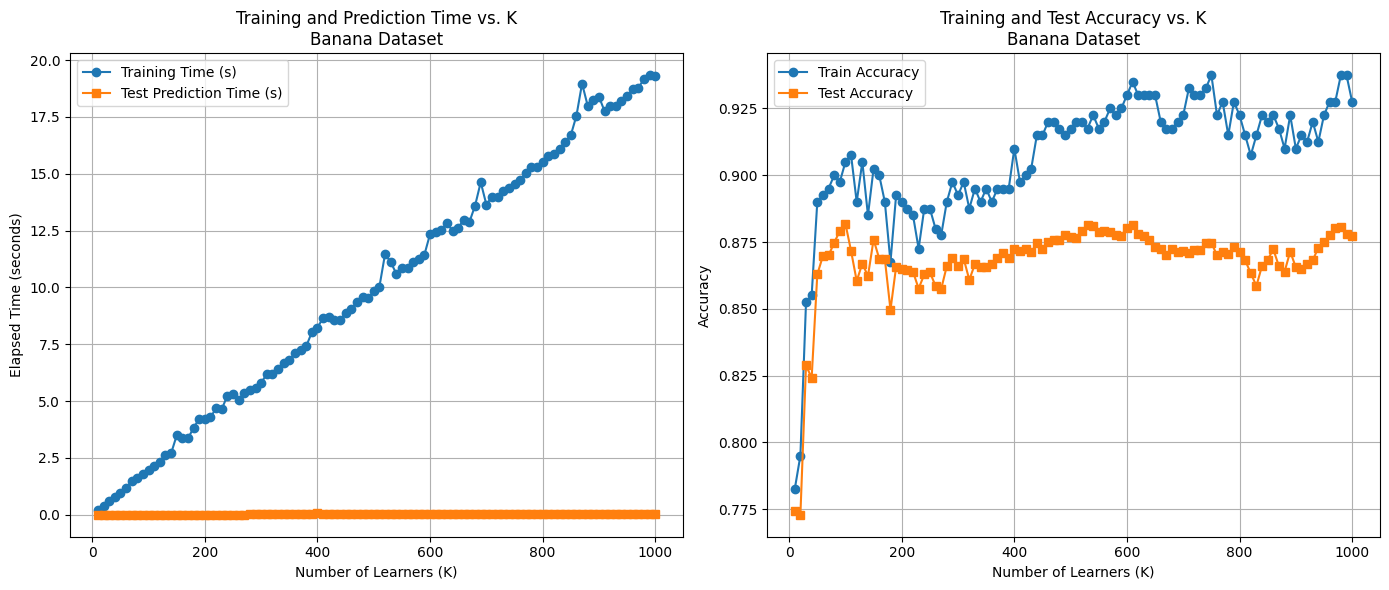

In [15]:
plot_adaboost_analysis(K_values, train_times, test_times, train_accuracies, test_accuracies, title="Banana Dataset")

# Adaboost: Splice Dataset

Train and test your Boosted Perceptron on the splice dataset and plot the accuracy vs K curves for both training and test. Use 1000 points for training, 2175 points for training, and K = 10,20,30,...1000

In [16]:
splice_df = pd.read_csv("splice_data.csv", header=None)
splice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2991 non-null   float64
 1   1       2991 non-null   float64
 2   2       2991 non-null   float64
 3   3       2991 non-null   float64
 4   4       2991 non-null   float64
 5   5       2991 non-null   float64
 6   6       2991 non-null   float64
 7   7       2991 non-null   float64
 8   8       2991 non-null   float64
 9   9       2991 non-null   float64
 10  10      2991 non-null   float64
 11  11      2991 non-null   float64
 12  12      2991 non-null   float64
 13  13      2991 non-null   float64
 14  14      2991 non-null   float64
 15  15      2991 non-null   float64
 16  16      2991 non-null   float64
 17  17      2991 non-null   float64
 18  18      2991 non-null   float64
 19  19      2991 non-null   float64
 20  20      2991 non-null   float64
 21  21      2991 non-null   float64
 22  

In [17]:
splice_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,...,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000
mean,-0.101304,2.490471,2.496824,2.526914,2.506854,2.507188,2.542962,2.504179,2.520227,2.541625,...,2.495152,2.435306,2.511535,2.508860,2.444333,2.504179,2.481779,2.507857,2.496824,2.484788
std,0.995022,1.086475,1.103918,1.081864,1.096606,1.118646,1.080726,1.107242,1.111889,1.102531,...,1.066623,1.094411,1.090143,1.077827,1.090316,1.101792,1.085440,1.083714,1.101795,1.080236
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,-1.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,3.000000,3.000000,2.000000
75%,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [18]:
splice_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,2.0,2.0,4.0,2.0,4.0,3.0,4.0,2.0,1.0
1,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,4.0,2.0,3.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0
2,-1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,4.0,...,3.0,3.0,2.0,3.0,3.0,1.0,4.0,2.0,2.0,3.0
3,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,4.0,...,4.0,2.0,4.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0
4,-1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,4.0,...,1.0,3.0,1.0,3.0,1.0,2.0,1.0,4.0,2.0,4.0


In [19]:
x = splice_df.iloc[:, 1:].to_numpy()
y = splice_df.iloc[:, 0].to_numpy()

In [20]:
x

array([[1., 1., 1., ..., 4., 2., 1.],
       [1., 1., 1., ..., 3., 1., 1.],
       [1., 1., 1., ..., 2., 2., 3.],
       ...,
       [4., 4., 4., ..., 3., 4., 3.],
       [4., 4., 4., ..., 1., 2., 2.],
       [4., 4., 4., ..., 2., 3., 3.]], shape=(2991, 60))

In [21]:
y

array([-1., -1., -1., ..., -1., -1.,  1.], shape=(2991,))

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(2175/len(splice_df)), random_state=42)

In [23]:
K_values = list(range(10, 1001, 10))
K_values, train_times, test_times, train_accuracies, test_accuracies = get_adaboost_analysis(x_train, y_train, x_test, y_test, K_values)

K=10: train_time=0.2013s, test_time=0.0012s, train_acc=0.8689, test_acc=0.8078
K=20: train_time=0.3868s, test_time=0.0020s, train_acc=0.8578, test_acc=0.8087
K=30: train_time=0.5845s, test_time=0.0032s, train_acc=0.8664, test_acc=0.8074
K=40: train_time=0.8111s, test_time=0.0037s, train_acc=0.8738, test_acc=0.8037
K=50: train_time=0.9967s, test_time=0.0044s, train_acc=0.8787, test_acc=0.8032
K=60: train_time=1.1696s, test_time=0.0057s, train_acc=0.8811, test_acc=0.8028
K=70: train_time=1.4891s, test_time=0.0089s, train_acc=0.8787, test_acc=0.8064
K=80: train_time=1.6162s, test_time=0.0072s, train_acc=0.8799, test_acc=0.8055
K=90: train_time=1.8088s, test_time=0.0090s, train_acc=0.8860, test_acc=0.8055
K=100: train_time=2.0604s, test_time=0.0093s, train_acc=0.8897, test_acc=0.8018
K=110: train_time=2.1944s, test_time=0.0096s, train_acc=0.8995, test_acc=0.7986
K=120: train_time=2.3670s, test_time=0.0099s, train_acc=0.8971, test_acc=0.8009
K=130: train_time=2.5419s, test_time=0.0115s, tra

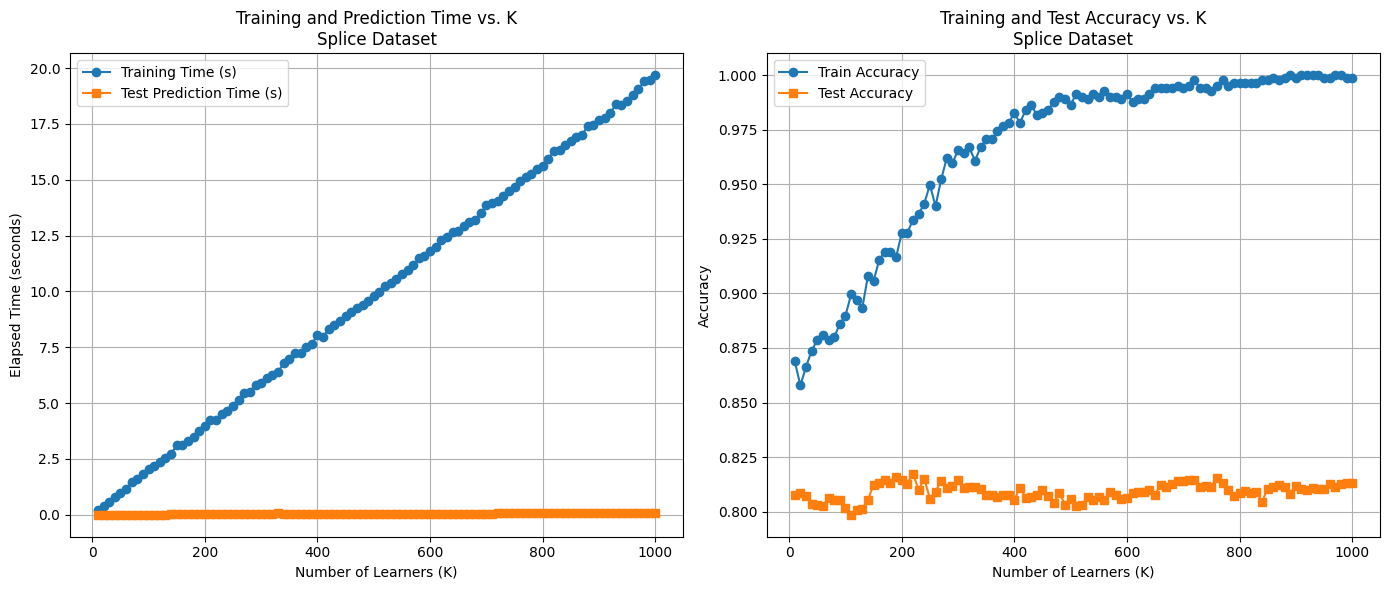

In [24]:
plot_adaboost_analysis(K_values, train_times, test_times, train_accuracies, test_accuracies, title="Splice Dataset")

# Running svmutils from libsvm3.17

In [25]:
import sys
your_libsvm_path = "./libsvm-3.17/python"
sys.path.append(your_libsvm_path)

In [26]:
import numpy as np
import time
from svmutil import svm_train, svm_predict

def svm_grid_search_metrics(x_train, y_train, x_test, y_test,
                            C_values, gamma_values):
    """
    Returns a list of dicts containing:
    - kernel_type
    - C
    - gamma
    - accuracy
    - train_time
    - test_time
    """
    results = []
    kernel_type = 2

    for C in C_values:
        for gamma in gamma_values:
            options = f'-s 0 -t {kernel_type} -c {C} -g {gamma} -q'

            # Time training
            t0 = time.perf_counter()
            model = svm_train(y_train, x_train, options)
            t1 = time.perf_counter()
            train_time = t1 - t0

            # Time prediction
            t2 = time.perf_counter()
            _, acc, _ = svm_predict(y_test, x_test, model, '-q')
            t3 = time.perf_counter()
            test_time = t3 - t2

            accuracy = acc[0]  # in percent

            results.append({
                "kernel_type": kernel_type,
                "C": C,
                "gamma": gamma,
                "accuracy": accuracy,
                "train_time": train_time,
                "test_time": test_time
            })

            print(f"kernel={kernel_type}, C={C:.1e}, γ={gamma:.1e} → acc={accuracy:.2f}%, train={train_time:.3f}s, test={test_time:.3f}s")

    return results

def find_best_svm_config(metrics):
    """
    Given a list of metric dictionaries (each with accuracy, train_time, test_time, etc.),
    returns the dictionary with the highest accuracy.
    """
    if not metrics:
        return None
    
    best_config = max(metrics, key=lambda x: x['accuracy'])
    return best_config



# Training SVM on Banana

In [27]:
from svmutil import svm_read_problem
from sklearn.model_selection import train_test_split

# 1) Read the entire Banana dataset in LIBSVM format.
y_list, x_list = svm_read_problem('banana_data.libsvm')

# 2) Split by index, but keep x_list as a list of dicts.
indices = np.arange(len(y_list))
train_idx, test_idx = train_test_split(indices, test_size=4900/5300, random_state=42)

y_train = [y_list[i] for i in train_idx]
x_train = [x_list[i] for i in train_idx]

y_test = [y_list[i] for i in test_idx]
x_test = [x_list[i] for i in test_idx]

In [28]:
best_accuracy = -1 * np.inf
best_C = 0
best_gamma = 0
best_kernel_type = 0

# 3) Define grid search for L
C_options = np.linspace(1e-3, 1e3)
gamma_options = np.linspace(1e-4, 1e1)

metrics = svm_grid_search_metrics(x_train, y_train, x_test, y_test,
                                  C_options, gamma_options)


kernel=2, C=1.0e-03, γ=1.0e-04 → acc=55.10%, train=0.013s, test=0.023s
kernel=2, C=1.0e-03, γ=2.0e-01 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=4.1e-01 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=6.1e-01 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=8.2e-01 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=1.0e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=1.2e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=1.4e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=1.6e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=1.8e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=2.0e+00 → acc=55.10%, train=0.002s, test=0.261s
kernel=2, C=1.0e-03, γ=2.2e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=2.4e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel=2, C=1.0e-03, γ=2.7e+00 → acc=55.10%, train=0.002s, test=0.022s
kernel

In [29]:
best = find_best_svm_config(metrics)
print("Best configuration:")
print(f"  Kernel type : {best['kernel_type']}")
print(f"  C           : {best['C']}")
print(f"  Gamma       : {best['gamma']}")
print(f"  Accuracy    : {best['accuracy']:.2f}%")
print(f"  Train time  : {best['train_time']:.4f}s")
print(f"  Test time   : {best['test_time']:.4f}s")

Best configuration:
  Kernel type : 2
  C           : 448.9801428571428
  Gamma       : 0.20417959183673468
  Accuracy    : 89.84%
  Train time  : 0.0029s
  Test time   : 0.0139s


# Training SVM on Splice

In [30]:
from svmutil import svm_read_problem

# 1) Read the entire Banana dataset in LIBSVM format.
y_list, x_list = svm_read_problem('splice_data.libsvm')

# 2) Split by index, but keep x_list as a list of dicts.
indices = np.arange(len(y_list))
train_idx, test_idx = train_test_split(indices, test_size=4900/5300, random_state=42)

y_train = [y_list[i] for i in train_idx]
x_train = [x_list[i] for i in train_idx]

y_test = [y_list[i] for i in test_idx]
x_test = [x_list[i] for i in test_idx]

In [31]:
best_accuracy = -1 * np.inf
best_C = 0
best_gamma = 0
best_kernel_type = 0

# 3) Define grid search for L
C_options = np.linspace(1e-3, 1e3)
gamma_options = np.linspace(1e-4, 1e1)

metrics = svm_grid_search_metrics(x_train, y_train, x_test, y_test,
                                  C_options, gamma_options)


kernel=2, C=1.0e-03, γ=1.0e-04 → acc=55.10%, train=0.007s, test=0.086s
kernel=2, C=1.0e-03, γ=2.0e-01 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=4.1e-01 → acc=55.10%, train=0.007s, test=0.082s
kernel=2, C=1.0e-03, γ=6.1e-01 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=8.2e-01 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=1.0e+00 → acc=55.10%, train=0.007s, test=0.082s
kernel=2, C=1.0e-03, γ=1.2e+00 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=1.4e+00 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=1.6e+00 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=1.8e+00 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=2.0e+00 → acc=55.10%, train=0.007s, test=0.082s
kernel=2, C=1.0e-03, γ=2.2e+00 → acc=55.10%, train=0.007s, test=0.082s
kernel=2, C=1.0e-03, γ=2.4e+00 → acc=55.10%, train=0.007s, test=0.083s
kernel=2, C=1.0e-03, γ=2.7e+00 → acc=55.10%, train=0.007s, test=0.083s
kernel

In [32]:
best = find_best_svm_config(metrics)
print("Best configuration:")
print(f"  Kernel type : {best['kernel_type']}")
print(f"  C           : {best['C']}")
print(f"  Gamma       : {best['gamma']}")
print(f"  Accuracy    : {best['accuracy']:.2f}%")
print(f"  Train time  : {best['train_time']:.4f}s")
print(f"  Test time   : {best['test_time']:.4f}s")

Best configuration:
  Kernel type : 2
  C           : 20.409142857142857
  Gamma       : 0.0001
  Accuracy    : 81.09%
  Train time  : 0.0063s
  Test time   : 0.0755s
